In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy import stats

%matplotlib inline
plt.rcParams['figure.figsize'] = (10,5)

DATA_PATH = "/kaggle/input/sensor3data/Copy of ESP32 Data - Sensor3.csv"

In [2]:
df = pd.read_csv(DATA_PATH)
print("Rows,Cols:", df.shape)
display(df.head(7))
display(df.columns.tolist())
display(df.describe(include='all').T)

Rows,Cols: (341, 7)


,Timestamp,MAX6675_TEMP_C,Custom_ADC,Custom_Vout,Custom_Resistance,Env_Temp_C,Env_Humidity_%
0,10/5/2025 0:59:01,26.00,2112,1.702,9389.20,25.37,58.63
1,10/5/2025 0:59:12,26.25,2119,1.708,9325.15,25.12,58.96
2,10/5/2025 0:59:19,26.50,2131,1.717,9216.33,24.82,60.17
3,10/5/2025 0:59:32,26.50,2112,1.702,9389.20,24.59,61.84
4,10/5/2025 0:59:42,26.00,2101,1.693,9490.72,24.41,61.68
5,10/5/2025 0:59:58,26.25,2114,1.704,9370.86,24.27,62.12
6,10/5/2025 1:00:06,26.25,2170,1.749,8870.97,24.15,62.26


['Timestamp',
 'MAX6675_TEMP_C',
 'Custom_ADC',
 'Custom_Vout',
 'Custom_Resistance',
 'Env_Temp_C',
 'Env_Humidity_%']

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Timestamp,341,341,10/5/2025 2:01:27,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MAX6675_TEMP_C,341.0,NaN,NaN,NaN,41.909824,10.852763,26.0,32.75,39.0,52.25,63.25
Custom_ADC,341.0,NaN,NaN,NaN,2650.624633,126.418818,2101.0,2598.0,2658.0,2735.0,2990.0
Custom_Vout,341.0,NaN,NaN,NaN,2.136009,0.101886,1.693,2.094,2.142,2.204,2.41
Custom_Resistance,341.0,NaN,NaN,NaN,5487.426217,809.121747,3695.65,4972.58,5406.32,5762.13,9490.72
Env_Temp_C,341.0,NaN,NaN,NaN,25.456129,0.791252,23.26,25.21,25.64,26.08,26.42
Env_Humidity_%,341.0,NaN,NaN,NaN,69.419501,2.656167,58.63,67.62,70.39,71.42,72.77


In [3]:
# normalization
df.columns = [c.strip() for c in df.columns]   
df = df.rename(columns={
    'MAX6675_TEMP_C': 'T_plate',
    'Env_Temp_C': 'T_env',
    'Custom_Resistance': 'R',
    'Env_Humidity_%': 'H',
    'Timestamp': 'Timestamp'
})

df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce', dayfirst=False)
print("Parsed timestamps:", df['Timestamp'].isna().sum(), "failed to parse")
df = df.sort_values('Timestamp').reset_index(drop=True)

Parsed timestamps: 0 failed to parse


In [4]:
# remove invalid sentinel values and NaNs
invalid_mask = (df['T_env'] == -999) | (df['H'] == -999)
print("Rows with -999 sentinel in T_env or H:", invalid_mask.sum())
df_clean = df[~invalid_mask].copy()
df_clean = df_clean.dropna(subset=['T_plate','R'])  
print("After removing invalids:", df_clean.shape)

Rows with -999 sentinel in T_env or H: 0
After removing invalids: (341, 7)


In [5]:
# drop duplicates based on measured pair (T_plate, R)
# keeping first occurence
before = df_clean.shape[0]
df_clean = df_clean.drop_duplicates(subset=['T_plate','R'], keep='first').reset_index(drop=True)
after = df_clean.shape[0]
print(f"Dropped {before-after} exact duplicates; remaining {after} rows")

Dropped 9 exact duplicates; remaining 332 rows


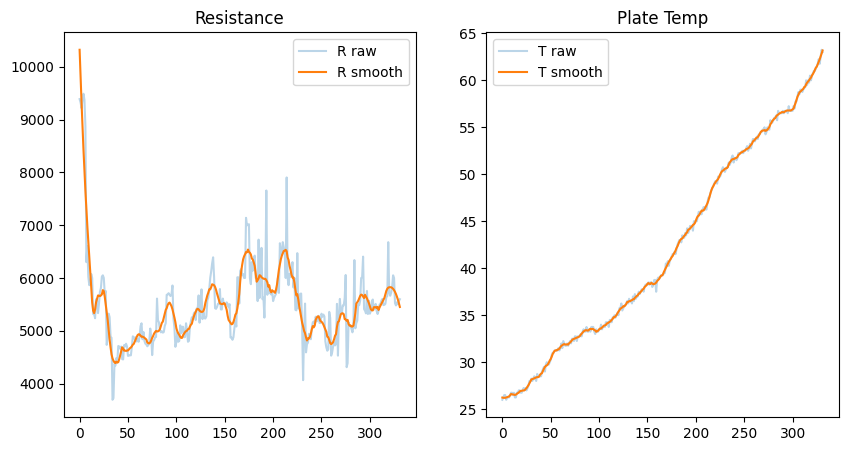

In [6]:
#  smoothing of curve between R and T_plate 
# reduce high-frequency noise
def safe_savgol(x, window=11, poly=2):
    if x.dropna().shape[0] < 5:
        return x  # nothing to do
    w = min(window, x.dropna().shape[0] if x.dropna().shape[0] % 2 == 1 else x.dropna().shape[0]-1)
    if w < 3:
        return x
    return pd.Series(savgol_filter(x, window_length=w, polyorder=poly), index=x.index)

df_clean['R_smooth'] = safe_savgol(df_clean['R'], window=21, poly=2)
df_clean['T_plate_smooth'] = safe_savgol(df_clean['T_plate'], window=11, poly=2)

plt.figure()
plt.subplot(1,2,1)
plt.plot(df_clean['R'], alpha=0.3, label='R raw')
plt.plot(df_clean['R_smooth'], label='R smooth')
plt.title('Resistance')
plt.legend()

plt.subplot(1,2,2)
plt.plot(df_clean['T_plate'], alpha=0.3, label='T raw')
plt.plot(df_clean['T_plate_smooth'], label='T smooth')
plt.title('Plate Temp')
plt.legend()
plt.show()


In [7]:
# Inter quartile range method to remove outliers 
def iqr_filter(series, k=1.5):
    q1, q3 = np.nanpercentile(series, [25,75])
    iqr = q3 - q1
    low = q1 - k*iqr
    high = q3 + k*iqr
    mask = (series >= low) & (series <= high)
    return mask, low, high

mask_R, lowR, highR = iqr_filter(df_clean['R_smooth'].values, k=1.5)
mask_T, lowT, highT = iqr_filter(df_clean['T_plate_smooth'].values, k=1.5)

combined_mask = mask_R & mask_T
print("Outliers flagged (rows removed):", (~combined_mask).sum(), "of", df_clean.shape[0])

df_no_out = df_clean[combined_mask].copy().reset_index(drop=True)
print("After outlier removal:", df_no_out.shape)

Outliers flagged (rows removed): 9 of 332
After outlier removal: (323, 9)


Original rows: 341
Cleaned rows: 323


,Timestamp,T_plate,T_plate_smooth,R,R_smooth,T_env,H
0,2025-10-05 01:00:40,26.75,26.613054,6027.40,6690.186320,23.89,63.76
1,2025-10-05 01:00:53,26.75,26.579254,5865.94,6426.305616,23.83,63.31
2,2025-10-05 01:01:01,26.50,26.572261,5884.41,6085.480677,23.69,64.63
3,2025-10-05 01:01:23,26.75,26.538462,6077.74,5789.620180,23.57,64.63
4,2025-10-05 01:01:35,26.25,26.513403,6002.34,5538.446473,23.55,64.46


Correlation matrix:


,T_plate_smooth,R_smooth,T_env,H
T_plate_smooth,1.000000,0.239178,0.850705,0.725246
R_smooth,0.239178,1.000000,0.272406,0.404835
T_env,0.850705,0.272406,1.000000,0.850384
H,0.725246,0.404835,0.850384,1.000000


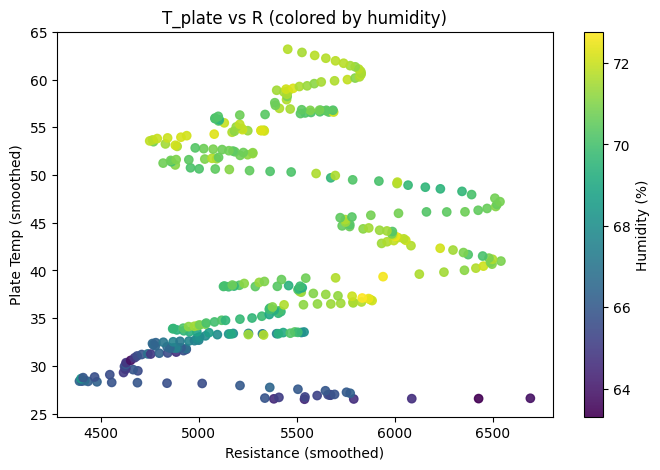

Saved cleaned dataset to: /kaggle/working/cleaned_sensor3.csv


In [9]:
# final cell
print("Original rows:", df.shape[0])
print("Cleaned rows:", df_no_out.shape[0])
display(df_no_out[['Timestamp','T_plate','T_plate_smooth','R','R_smooth','T_env','H']].head())

corr = df_no_out[['T_plate_smooth','R_smooth','T_env','H']].corr()
print("Correlation matrix:")
display(corr) #  correlation matrix 

plt.figure(figsize=(8,5))
sc = plt.scatter(df_no_out['R_smooth'], df_no_out['T_plate_smooth'], c=df_no_out['H'], cmap='viridis', alpha=0.9)
plt.colorbar(sc, label='Humidity (%)')
plt.xlabel('Resistance (smoothed)')
plt.ylabel('Plate Temp (smoothed)')
plt.title('T_plate vs R (colored by humidity)')
plt.show()

OUT_PATH = "/kaggle/working/cleaned_sensor3.csv"
df_no_out.to_csv(OUT_PATH, index=False)
print("Saved cleaned dataset to:", OUT_PATH)

In [10]:
# Cell A
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline
plt.rcParams['figure.figsize'] = (10,5)
sns.set(style="whitegrid")

CLEANED_PATH = "/kaggle/working/cleaned_sensor3.csv"
df = pd.read_csv(CLEANED_PATH)

if 'Timestamp' in df.columns:
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

print("Rows,Cols:", df.shape)
display(df.head())
display(df.describe().T)

Rows,Cols: (323, 9)


,Timestamp,T_plate,Custom_ADC,Custom_Vout,R,T_env,H,R_smooth,T_plate_smooth
0,2025-10-05 01:00:40,26.75,2555,2.059,6027.40,23.89,63.76,6690.186320,26.613054
1,2025-10-05 01:00:53,26.75,2581,2.080,5865.94,23.83,63.31,6426.305616,26.579254
2,2025-10-05 01:01:01,26.50,2578,2.078,5884.41,23.69,64.63,6085.480677,26.572261
3,2025-10-05 01:01:23,26.75,2547,2.053,6077.74,23.57,64.63,5789.620180,26.538462
4,2025-10-05 01:01:35,26.25,2559,2.062,6002.34,23.55,64.46,5538.446473,26.513403


,count,mean,min,25%,50%,75%,max,std
Timestamp,323,2025-10-05 01:31:29.563467520,2025-10-05 01:00:40,2025-10-05 01:16:29,2025-10-05 01:31:39,2025-10-05 01:46:45,2025-10-05 02:01:27,NaN
T_plate,323.0,42.547214,26.25,33.25,40.25,52.5,63.25,10.705468
Custom_ADC,323.0,2662.603715,2287.0,2606.0,2661.0,2735.5,2990.0,100.606504
Custom_Vout,323.0,2.145659,1.843,2.1,2.144,2.2045,2.41,0.081094
R,323.0,5401.912415,3695.65,4969.845,5388.95,5713.74,7905.55,591.357244
T_env,323.0,25.493591,23.26,25.25,25.67,26.09,26.42,0.781136
H,323.0,69.673808,63.31,68.175,70.43,71.44,72.77,2.282479
R_smooth,323.0,5404.034343,4390.89354,5003.885347,5390.07321,5726.85526,6690.18632,502.02384
T_plate_smooth,323.0,42.546714,26.513403,33.367716,40.245338,52.529429,63.18007,10.703848


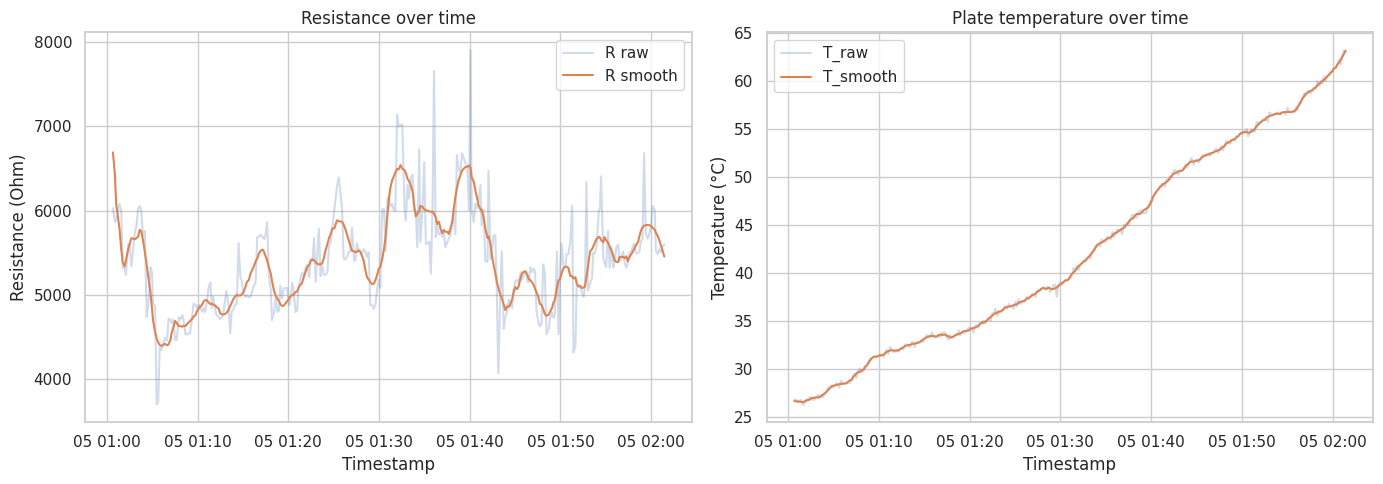

In [11]:
# Cell B:  resistance & plate temp 
plt.figure(figsize=(14,5))
ax1 = plt.subplot(1,2,1)
if 'Timestamp' in df.columns:
    plt.plot(df['Timestamp'], df['R'], alpha=0.25, label='R raw')
    plt.plot(df['Timestamp'], df['R_smooth'], label='R smooth')
    plt.xlabel('Timestamp')
else:
    plt.plot(df.index, df['R'], alpha=0.25, label='R raw')
    plt.plot(df.index, df['R_smooth'], label='R smooth')
plt.title('Resistance over time')
plt.ylabel('Resistance (Ohm)')
plt.legend()

ax2 = plt.subplot(1,2,2)
if 'Timestamp' in df.columns:
    plt.plot(df['Timestamp'], df['T_plate'], alpha=0.25, label='T_raw')
    plt.plot(df['Timestamp'], df['T_plate_smooth'], label='T_smooth')
    plt.xlabel('Timestamp')
else:
    plt.plot(df.index, df['T_plate'], alpha=0.25, label='T_raw')
    plt.plot(df.index, df['T_plate_smooth'], label='T_smooth')
plt.title('Plate temperature over time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.tight_layout()
plt.show()

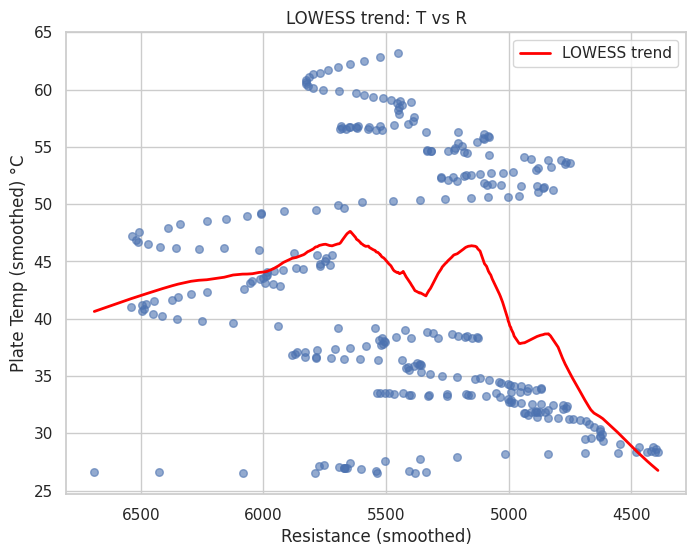

In [12]:
# Cell D: Lowess smoothing 
try:
    import statsmodels.api as sm
    lowess = sm.nonparametric.lowess
    tmp = df[['R_smooth','T_plate_smooth']].dropna().sort_values('R_smooth')
    z = lowess(tmp['T_plate_smooth'], tmp['R_smooth'], frac=0.2)
    plt.figure(figsize=(8,6))
    plt.scatter(tmp['R_smooth'], tmp['T_plate_smooth'], alpha=0.6, s=30)
    plt.plot(z[:,0], z[:,1], color='red', linewidth=2, label='LOWESS trend')
    plt.xlabel('Resistance (smoothed)')
    plt.ylabel('Plate Temp (smoothed) °C')
    plt.title('LOWESS trend: T vs R')
    plt.legend()
    plt.gca().invert_xaxis()
    plt.show()
except Exception as e:
    print("statsmodels not available or LOWESS failed:", e)

    coeffs = np.polyfit(df['R_smooth'].dropna(), df['T_plate_smooth'].dropna(), deg=2)
    poly = np.poly1d(coeffs)
    xs = np.linspace(df['R_smooth'].min(), df['R_smooth'].max(), 200)
    plt.scatter(df['R_smooth'], df['T_plate_smooth'], alpha=0.5)
    plt.plot(xs, poly(xs), color='red', label='poly2 fit')
    plt.legend()
    plt.gca().invert_xaxis()
    plt.show()

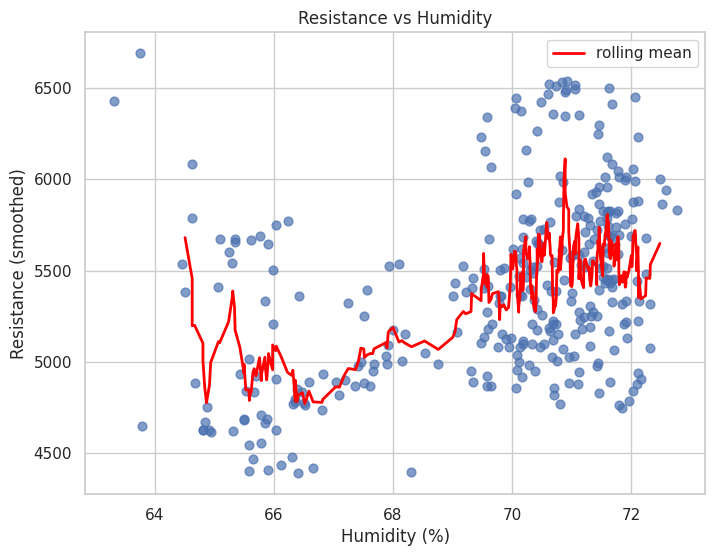

Pearson r (H vs R_smooth): 0.4048, p-value: 3.61e-14


In [13]:
# Cell E: scatter R_smooth vs humidity - rolling-mean trend
plt.figure(figsize=(8,6))
plt.scatter(df['H'], df['R_smooth'], alpha=0.7, s=40)
# rolling mean --> H sorting
tmp = df[['H','R_smooth']].dropna().sort_values('H')
rolling = tmp['R_smooth'].rolling(window=max(3, int(len(tmp)/40)), center=True).mean()
plt.plot(tmp['H'], rolling, color='red', linewidth=2, label='rolling mean')
plt.xlabel('Humidity (%)')
plt.ylabel('Resistance (smoothed)')
plt.title('Resistance vs Humidity')
plt.legend()
plt.grid(True)
plt.show()

r_h, p_h = stats.pearsonr(df['H'].dropna(), df['R_smooth'].dropna())
print(f"Pearson r (H vs R_smooth): {r_h:.4f}, p-value: {p_h:.2e}")

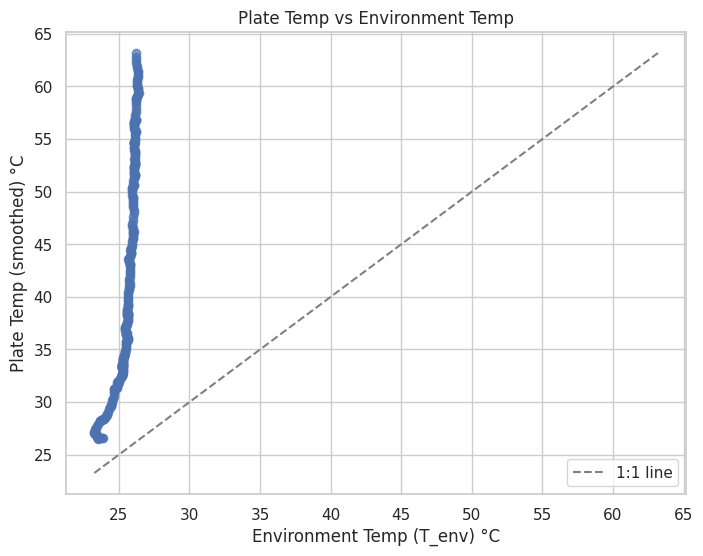

Pearson r (T_env vs T_plate_smooth): 0.8507, p-value: 1.15e-91


In [14]:
# Cell F: plate temperature (measured) vs environment temperature
plt.figure(figsize=(8,6))
plt.scatter(df['T_env'], df['T_plate_smooth'], alpha=0.7)
plt.xlabel('Environment Temp (T_env) °C')
plt.ylabel('Plate Temp (smoothed) °C')
plt.title('Plate Temp vs Environment Temp')
mn = min(df['T_env'].min(), df['T_plate_smooth'].min())
mx = max(df['T_env'].max(), df['T_plate_smooth'].max())
plt.plot([mn,mx],[mn,mx], '--', color='gray', label='1:1 line')
plt.legend()
plt.grid(True)
plt.show()

r_te, p_te = stats.pearsonr(df['T_env'].dropna(), df['T_plate_smooth'].dropna())
print(f"Pearson r (T_env vs T_plate_smooth): {r_te:.4f}, p-value: {p_te:.2e}")

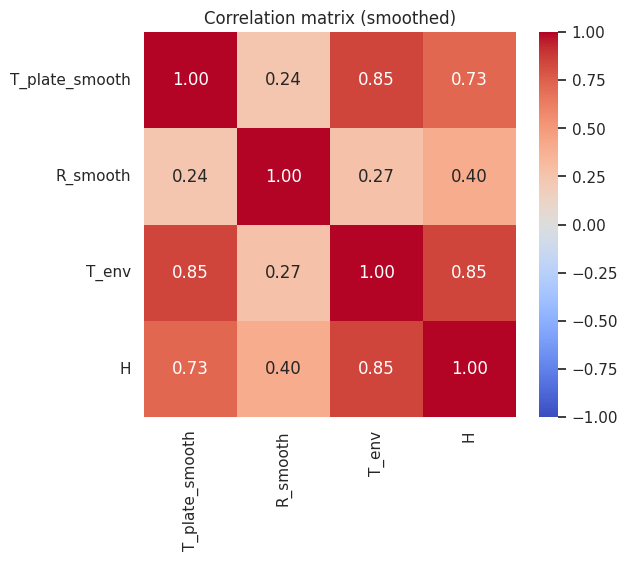

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

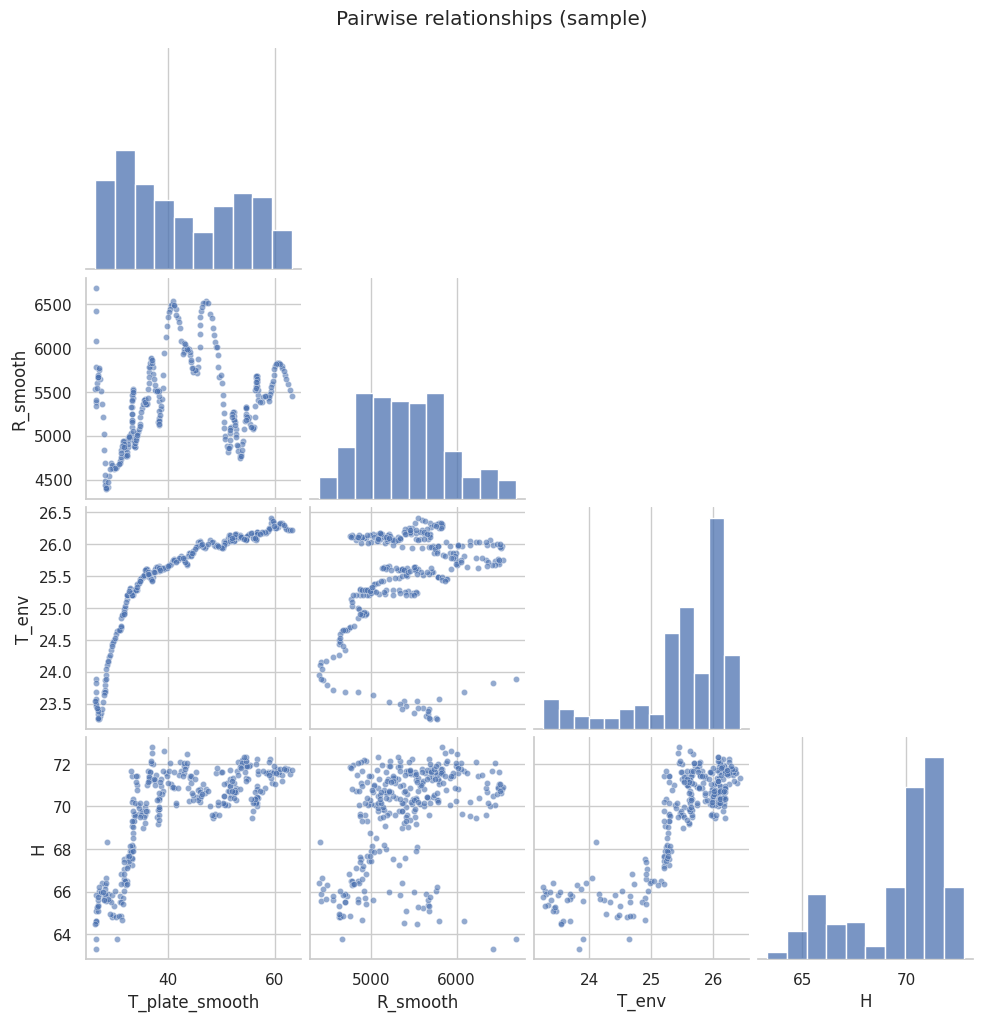

In [15]:
# Cell G: correlation heatmap and seaborn pairplot
cols = ['T_plate_smooth', 'R_smooth', 'T_env', 'H']
corr = df[cols].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation matrix (smoothed)')
plt.show()

# Pairplot
sample = df[cols].dropna().sample(n=min(1000, len(df)), random_state=42)
sns.pairplot(sample, corner=True, plot_kws={'s':20, 'alpha':0.6})
plt.suptitle('Pairwise relationships (sample)', y=1.02)
plt.show()

/tmp/ipykernel_37/1517634393.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group = df.groupby('T_bin').agg({


,T_mean,R_mean,R_std,count,H_mean
0,26.747490,5763.888855,405.084996,13,64.900000
1,27.200029,5715.307738,57.818112,4,65.985000
2,27.752525,5358.678375,147.740364,3,66.126667
3,28.320124,4580.312470,221.734504,9,66.000000
4,28.762821,4425.647117,37.223431,3,66.623333
5,29.293124,4616.775364,71.616407,3,65.343333
6,29.747086,4634.376951,20.284285,4,65.225000
7,30.258159,4628.339276,0.059331,2,65.425000
8,30.718240,4662.129078,14.432588,2,64.315000
9,31.271146,4772.906934,71.879802,7,65.647143


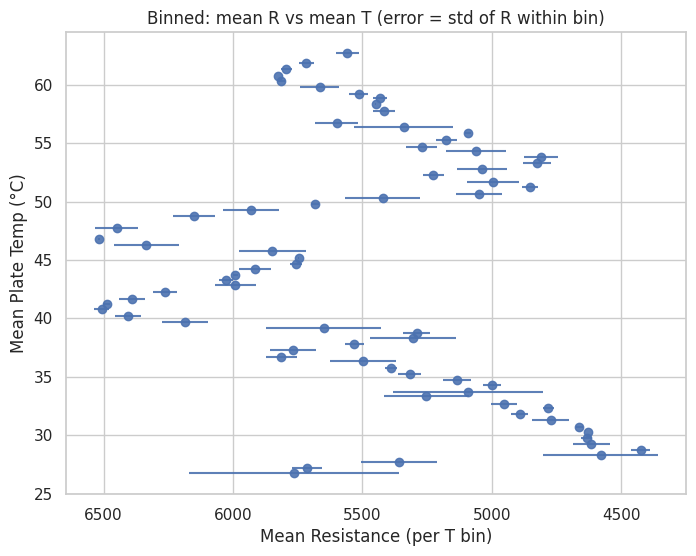

In [16]:
# Cell H: Bin temperature and compute mean
bins = np.arange(df['T_plate_smooth'].min()-0.5, df['T_plate_smooth'].max()+0.5, 0.5)
df['T_bin'] = pd.cut(df['T_plate_smooth'], bins=bins)
group = df.groupby('T_bin').agg({
    'T_plate_smooth': 'mean',
    'R_smooth': ['mean','std','count'],
    'H': 'mean'
})
group.columns = ['T_mean','R_mean','R_std','count','H_mean']
group = group.dropna().reset_index(drop=True)
display(group.head(12))

plt.figure(figsize=(8,6))
plt.errorbar(group['R_mean'], group['T_mean'], yerr=None, xerr=group['R_std'], fmt='o', alpha=0.9)
plt.xlabel('Mean Resistance (per T bin)')
plt.ylabel('Mean Plate Temp (°C)')
plt.title('Binned: mean R vs mean T (error = std of R within bin)')
plt.gca().invert_xaxis()
plt.grid(True)
plt.show()

Selected features used: ['R', 'Tenv', 'H', 'R^2']
Coefficients: [ 8.79042915e-04  1.16913624e+01 -1.57092014e-01 -2.74326166e-06]
Intercept: -243.87366310367747
R2: 0.7292144973922788
RMSE: 5.561338326190361


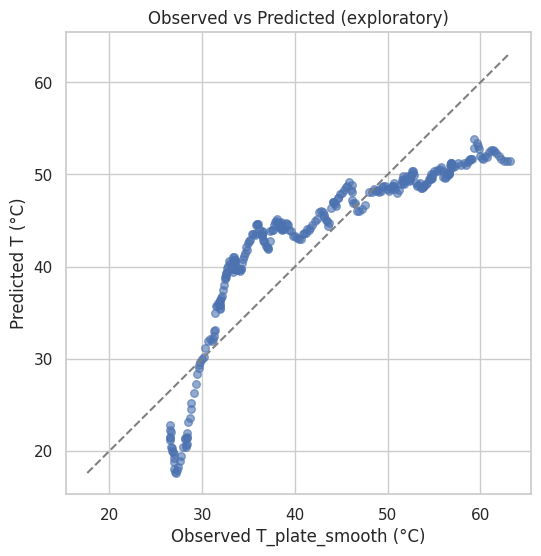

In [17]:
# Cell I: exploratory regression: T_plate_smooth ~ R_smooth + T_env + H (with polynomial R^2)
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error

sub = df[['T_plate_smooth','R_smooth','T_env','H']].dropna()
X = sub[['R_smooth','T_env','H']].values
y = sub['T_plate_smooth'].values

R_mean = X[:,0].mean()
X[:,0] = X[:,0] - R_mean

# polynomial features for R
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X) 

feat_names = poly.get_feature_names_out(['R','Tenv','H'])
Xpf = pd.DataFrame(X_poly, columns=feat_names)

select_cols = [c for c in Xpf.columns if c in ['R','R^2','Tenv','H']]
X_model = Xpf[select_cols].values

lr = LinearRegression()
lr.fit(X_model, y)
y_pred = lr.predict(X_model)
print("Selected features used:", select_cols)
print("Coefficients:", lr.coef_)
print("Intercept:", lr.intercept_)
print("R2:", r2_score(y, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))

plt.figure(figsize=(6,6))
plt.scatter(y, y_pred, alpha=0.6, s=30)
mn = min(y.min(), y_pred.min()); mx = max(y.max(), y_pred.max())
plt.plot([mn,mx],[mn,mx], '--', color='gray')
plt.xlabel('Observed T_plate_smooth (°C)')
plt.ylabel('Predicted T (°C)')
plt.title('Observed vs Predicted (exploratory)')
plt.grid(True)
plt.show()

In [18]:
# Cell J: compare three functional forms for T=f(R,H)

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

dfm = df[['T_plate_smooth','R_smooth','H']].dropna()
R = dfm['R_smooth'].values.reshape(-1,1)
H = dfm['H'].values.reshape(-1,1)
T = dfm['T_plate_smooth'].values

# helper to evaluate a model
def eval_model(X, y):
    lr = LinearRegression().fit(X, y)
    y_pred = lr.predict(X)
    return lr, r2_score(y, y_pred), np.sqrt(mean_squared_error(y, y_pred))

# Model 1: Polynomial (R + R^2 + H)
X_poly = np.hstack([R, R**2, H])
m1, r2_1, rmse_1 = eval_model(X_poly, T)

# Model 2: Logarithmic (ln R + H)
X_log = np.hstack([np.log(R), H])
m2, r2_2, rmse_2 = eval_model(X_log, T)

# Model 3: Inverse (1/R + H)
X_inv = np.hstack([1/R, H])
m3, r2_3, rmse_3 = eval_model(X_inv, T)

print(f"Model 1 (poly):  R2={r2_1:.3f}, RMSE={rmse_1:.2f}")
print(f"Model 2 (log):   R2={r2_2:.3f}, RMSE={rmse_2:.2f}")
print(f"Model 3 (1/R):   R2={r2_3:.3f}, RMSE={rmse_3:.2f}")


Model 1 (poly):  R2=0.533, RMSE=7.31
Model 2 (log):   R2=0.529, RMSE=7.33
Model 3 (1/R):   R2=0.529, RMSE=7.34



Best model: POLY with R2=0.533, RMSE=7.31
T = -250.097 + 0.021156*R + -2.037466e-06*R² + 3.4207*H


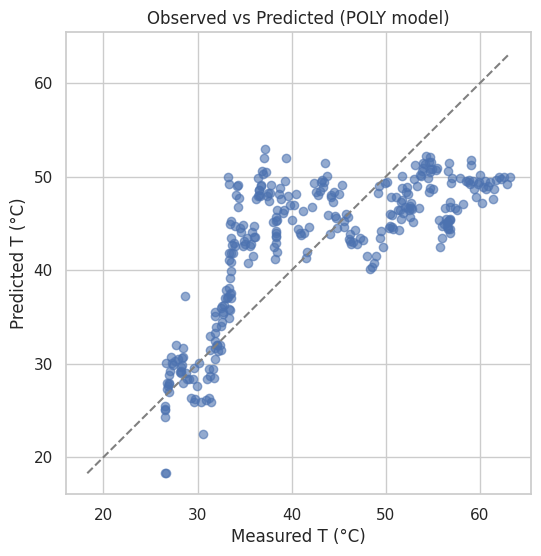

In [19]:
# Cell K: choose best model and show its equation + plot
import matplotlib.pyplot as plt

# choose best by R2
models = {'poly':(m1,r2_1,rmse_1), 'log':(m2,r2_2,rmse_2), 'inv':(m3,r2_3,rmse_3)}
best_name, (best_model, best_r2, best_rmse) = max(models.items(), key=lambda x: x[1][1])

print(f"\nBest model: {best_name.upper()} with R2={best_r2:.3f}, RMSE={best_rmse:.2f}")

if best_name == 'poly':
    coefs = best_model.coef_
    intercept = best_model.intercept_
    print(f"T = {intercept:.3f} + {coefs[0]:.6f}*R + {coefs[1]:.6e}*R² + {coefs[2]:.4f}*H")

elif best_name == 'log':
    coefs = best_model.coef_
    intercept = best_model.intercept_
    print(f"T = {intercept:.3f} + {coefs[0]:.3f}*ln(R) + {coefs[1]:.3f}*H")

elif best_name == 'inv':
    coefs = best_model.coef_
    intercept = best_model.intercept_
    print(f"T = {intercept:.3f} + {coefs[0]:.3f}/R + {coefs[1]:.3f}*H")

# visualize predicted vs actual
X_best = {'poly': np.hstack([R, R**2, H]),
          'log': np.hstack([np.log(R), H]),
          'inv': np.hstack([1/R, H])}[best_name]

y_pred = best_model.predict(X_best)

plt.figure(figsize=(6,6))
plt.scatter(T, y_pred, alpha=0.6)
mn, mx = min(T.min(), y_pred.min()), max(T.max(), y_pred.max())
plt.plot([mn,mx],[mn,mx],'--',color='gray')
plt.xlabel('Measured T (°C)')
plt.ylabel('Predicted T (°C)')
plt.title(f'Observed vs Predicted ({best_name.upper()} model)')
plt.grid(True)
plt.show()


# Improvement
### Polynomial Regression (degree=4)
### Random Forest Regressor (non-parametric)
### Gaussian Process Regressor (GPR)
### Cross-validation

In [20]:
# Cell L: setup for nonlinear regression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import r2_score, mean_squared_error

# Load cleaned dataset
dfm = df[['T_plate_smooth','R_smooth','H']].dropna()
X = dfm[['R_smooth','H']].values
y = dfm['T_plate_smooth'].values

# Train-test split (70-30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Train:", X_train.shape, " Test:", X_test.shape)


Train: (226, 2)  Test: (97, 2)


Polynomial(4) model → R2 = 0.618, RMSE = 6.68


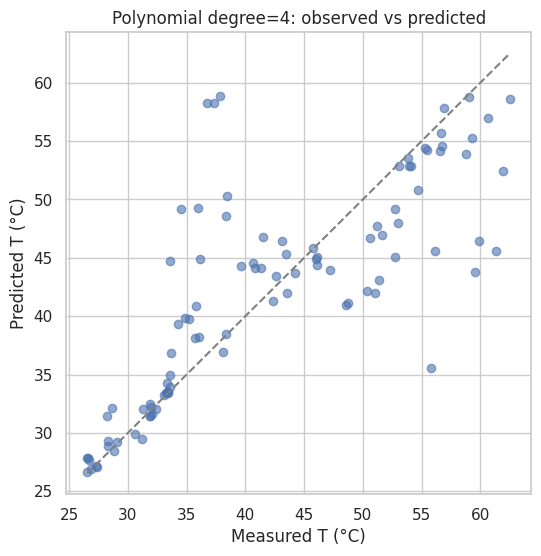

In [21]:
# Cell M: higher-degree polynomial regression
poly_model = make_pipeline(PolynomialFeatures(degree=4, include_bias=False), 
                           StandardScaler(with_mean=False),
                           RandomForestRegressor(random_state=42, n_estimators=200))

poly_model.fit(X_train, y_train)
y_pred_poly = poly_model.predict(X_test)

r2_poly = r2_score(y_test, y_pred_poly)
rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))

print(f"Polynomial(4) model → R2 = {r2_poly:.3f}, RMSE = {rmse_poly:.2f}")

# Visual check
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_poly, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()],'--',color='gray')
plt.xlabel('Measured T (°C)')
plt.ylabel('Predicted T (°C)')
plt.title('Polynomial degree=4: observed vs predicted')
plt.grid(True)
plt.show()


Random Forest → R2 = 0.624, RMSE = 6.63


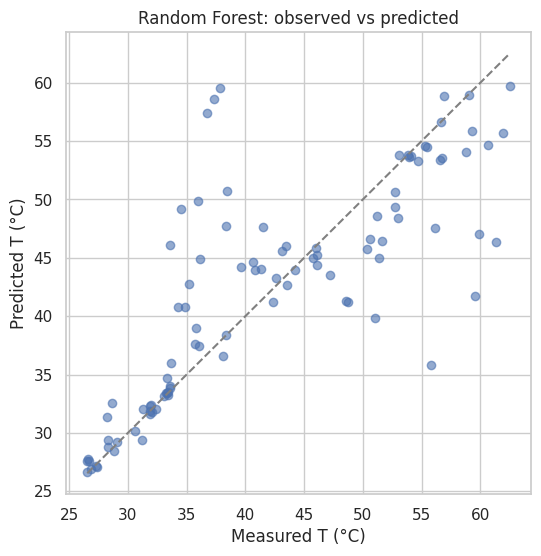

In [22]:
# Cell N: random forest
rf = RandomForestRegressor(n_estimators=400, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f"Random Forest → R2 = {r2_rf:.3f}, RMSE = {rmse_rf:.2f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],[y_test.min(),y_test.max()],'--',color='gray')
plt.xlabel('Measured T (°C)')
plt.ylabel('Predicted T (°C)')
plt.title('Random Forest: observed vs predicted')
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 10.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 10.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Gaussian Process → R2 = -1.633, RMSE = 17.54


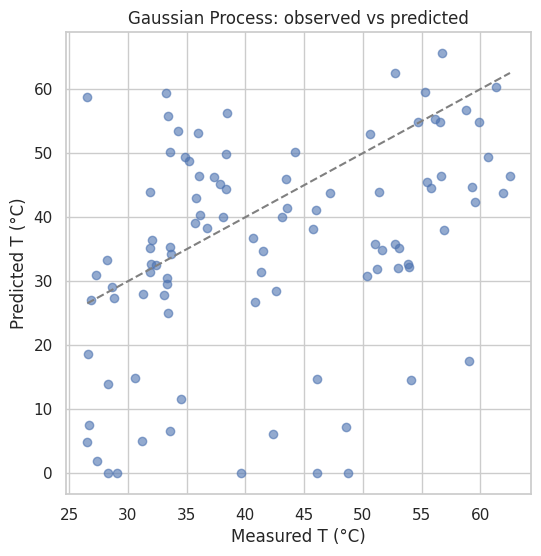

In [23]:
# Cell O: Gaussian Process Regression (smooth calibration curve)
kernel = C(1.0, (1e-2, 1e3)) * RBF(length_scale=[1e3, 1e1], length_scale_bounds=(1e1, 1e5))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, alpha=5.0)

gpr.fit(X_train, y_train)
y_pred_gpr = gpr.predict(X_test)

r2_gpr = r2_score(y_test, y_pred_gpr)
rmse_gpr = np.sqrt(mean_squared_error(y_test, y_pred_gpr))

print(f"Gaussian Process → R2 = {r2_gpr:.3f}, RMSE = {rmse_gpr:.2f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_gpr, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],[y_test.min(),y_test.max()],'--',color='gray')
plt.xlabel('Measured T (°C)')
plt.ylabel('Predicted T (°C)')
plt.title('Gaussian Process: observed vs predicted')
plt.grid(True)
plt.show()


In [24]:
# Cell P: compare all three models using cross-validation (5-fold)
from sklearn.model_selection import cross_val_score

models = {
    "Polynomial(4)": poly_model,
    "RandomForest": rf,
    "GaussianProcess": gpr
}

print("Cross-validation (R² mean ± std):")
for name, model in models.items():
    scores = cross_val_score(model, X, y, scoring='r2', cv=5)
    print(f"{name:15s} → R² = {scores.mean():.3f} ± {scores.std():.3f}")


Cross-validation (R² mean ± std):
Polynomial(4)   → R² = -31.247 ± 27.012
RandomForest    → R² = -31.766 ± 25.572


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 10.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 10.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarn

GaussianProcess → R² = -87.082 ± 24.195


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 10.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


# Alternative Approach

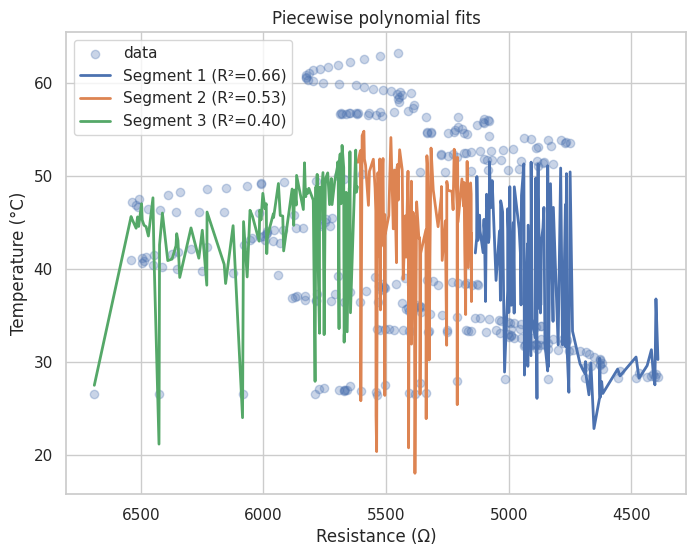

Segment R² values: [0.656 0.532 0.398]
Average R²: 0.5285549353139704


In [25]:
# Cell T: piecewise polynomial regression to capture multiple temperature regimes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

dfc = df[['T_plate_smooth','R_smooth','H']].dropna()
X = dfc[['R_smooth','H']].values
y = dfc['T_plate_smooth'].values

# sort by R (for piecewise segmentation)
order = np.argsort(X[:,0])
R_sorted, H_sorted, T_sorted = X[:,0][order], X[:,1][order], y[order]

# divide into 3 segments automatically
segments = np.array_split(np.arange(len(R_sorted)), 3)

models = []
r2_total = []
plt.figure(figsize=(8,6))
plt.scatter(R_sorted, T_sorted, alpha=0.3, label='data')

for i, seg in enumerate(segments):
    R_seg, H_seg, T_seg = R_sorted[seg], H_sorted[seg], T_sorted[seg]
    X_seg = np.column_stack([R_seg, R_seg**2, H_seg])
    model = LinearRegression().fit(X_seg, T_seg)
    y_pred = model.predict(X_seg)
    models.append(model)
    r2_total.append(r2_score(T_seg, y_pred))
    plt.plot(R_seg, y_pred, lw=2, label=f'Segment {i+1} (R²={r2_total[-1]:.2f})')

plt.gca().invert_xaxis()
plt.xlabel('Resistance (Ω)')
plt.ylabel('Temperature (°C)')
plt.title('Piecewise polynomial fits')
plt.legend()
plt.grid(True)
plt.show()

print("Segment R² values:", np.round(r2_total,3))
print("Average R²:", np.mean(r2_total))


Gradient Boosting → R2=0.675, RMSE=6.34


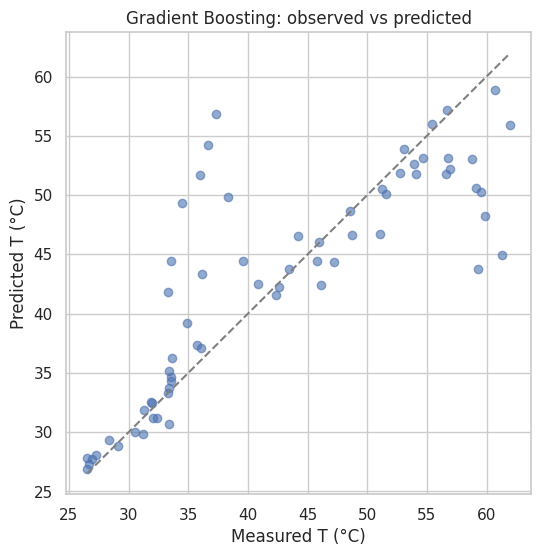

In [26]:
# Cell U: Gradient Boosting Regressor (nonlinear smoother)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

dfc = df[['T_plate_smooth','R_smooth','H']].dropna()
X = dfc[['R_smooth','H']].values
y = dfc['T_plate_smooth'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gbr = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=3,
    subsample=0.9,
    random_state=42
)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)

r2_gbr = r2_score(y_test, y_pred)
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Gradient Boosting → R2={r2_gbr:.3f}, RMSE={rmse_gbr:.2f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()],'--',color='gray')
plt.xlabel('Measured T (°C)')
plt.ylabel('Predicted T (°C)')
plt.title('Gradient Boosting: observed vs predicted')
plt.grid(True)
plt.show()


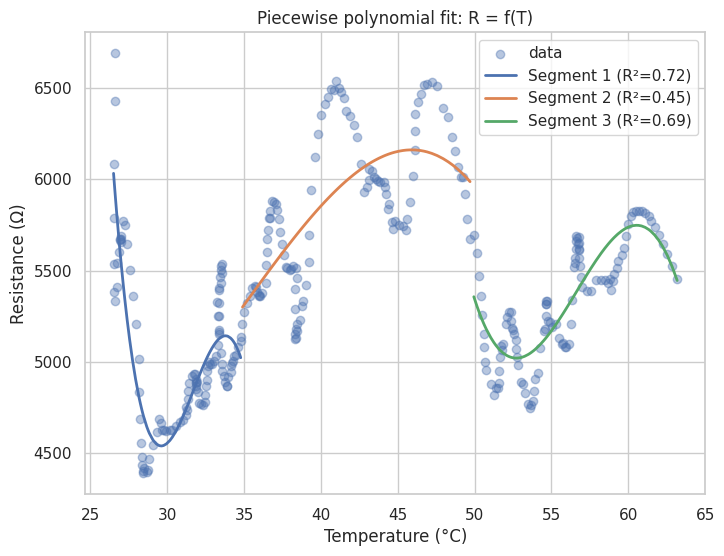

Segment R² values: [0.72  0.452 0.685]


In [27]:
# Cell V: Fit R = f(T) in segments, then later invert

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

dfc = df[['T_plate_smooth','R_smooth']].dropna().sort_values('T_plate_smooth')
T = dfc['T_plate_smooth'].values
R = dfc['R_smooth'].values

# Split into 3 segments based on T ranges
segments = np.array_split(np.arange(len(T)), 3)
models = []
r2s = []

plt.figure(figsize=(8,6))
plt.scatter(T, R, alpha=0.4, label='data')

for i, seg in enumerate(segments):
    T_seg, R_seg = T[seg], R[seg]
    poly = PolynomialFeatures(degree=3, include_bias=False)
    X_poly = poly.fit_transform(T_seg.reshape(-1,1))
    lin = LinearRegression().fit(X_poly, R_seg)
    R_pred = lin.predict(X_poly)
    models.append((poly, lin))
    r2s.append(r2_score(R_seg, R_pred))
    plt.plot(T_seg, R_pred, lw=2, label=f'Segment {i+1} (R²={r2s[-1]:.2f})')

plt.xlabel('Temperature (°C)')
plt.ylabel('Resistance (Ω)')
plt.title('Piecewise polynomial fit: R = f(T)')
plt.legend()
plt.grid(True)
plt.show()

print("Segment R² values:", np.round(r2s,3))


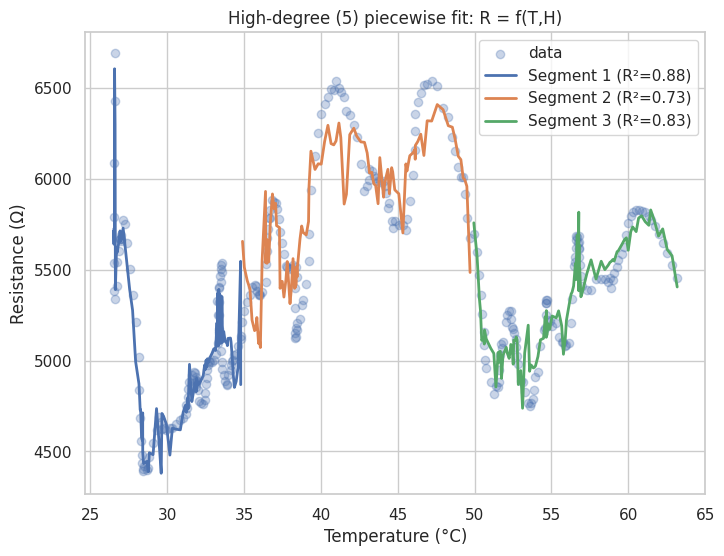

Segment R² values: [0.875 0.726 0.826]
Average R²: 0.8091801676131533


In [28]:
# Cell Y: Higher-degree (deg=5) polynomial fit R = f(T,H)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

dfc = df[['T_plate_smooth','R_smooth','H']].dropna().sort_values('T_plate_smooth')
T = dfc['T_plate_smooth'].values
R = dfc['R_smooth'].values
H = dfc['H'].values

segments = np.array_split(np.arange(len(T)), 3)
models = []
r2s = []

plt.figure(figsize=(8,6))
plt.scatter(T, R, alpha=0.3, label='data')

for i, seg in enumerate(segments):
    T_seg, H_seg, R_seg = T[seg], H[seg], R[seg]
    X_seg = np.column_stack([T_seg, H_seg])
    poly = PolynomialFeatures(degree=5, include_bias=False)
    X_poly = poly.fit_transform(X_seg)
    lin = LinearRegression().fit(X_poly, R_seg)
    R_pred = lin.predict(X_poly)
    models.append((poly, lin))
    r2s.append(r2_score(R_seg, R_pred))
    plt.plot(T_seg, R_pred, lw=2, label=f'Segment {i+1} (R²={r2s[-1]:.2f})')

plt.xlabel('Temperature (°C)')
plt.ylabel('Resistance (Ω)')
plt.title('High-degree (5) piecewise fit: R = f(T,H)')
plt.legend()
plt.grid(True)
plt.show()

print("Segment R² values:", np.round(r2s,3))
print("Average R²:", np.mean(r2s))


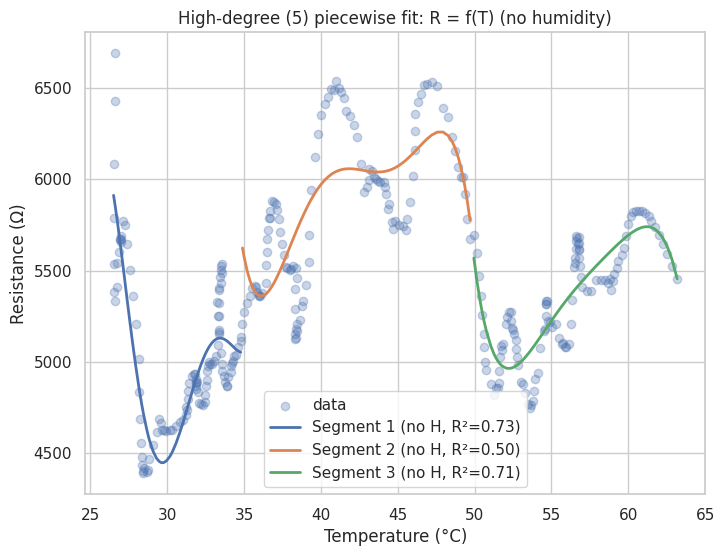

Segment R² (no humidity): [0.733 0.499 0.713]
Average R² (no humidity): 0.6485407775948109


In [29]:
# Cell Z: Same degree but exclude humidity to compare
r2s_noH = []
plt.figure(figsize=(8,6))
plt.scatter(T, R, alpha=0.3, label='data')

for i, seg in enumerate(segments):
    T_seg, R_seg = T[seg], R[seg]
    poly = PolynomialFeatures(degree=5, include_bias=False)
    X_poly = poly.fit_transform(T_seg.reshape(-1,1))
    lin = LinearRegression().fit(X_poly, R_seg)
    R_pred = lin.predict(X_poly)
    r2s_noH.append(r2_score(R_seg, R_pred))
    plt.plot(T_seg, R_pred, lw=2, label=f'Segment {i+1} (no H, R²={r2s_noH[-1]:.2f})')

plt.xlabel('Temperature (°C)')
plt.ylabel('Resistance (Ω)')
plt.title('High-degree (5) piecewise fit: R = f(T) (no humidity)')
plt.legend()
plt.grid(True)
plt.show()

print("Segment R² (no humidity):", np.round(r2s_noH,3))
print("Average R² (no humidity):", np.mean(r2s_noH))



Segment 1 polynomial terms:
  T         :  4.452e+07
  H         : -7.307e+07
  T^2       :  2.647e+06
  T H       : -5.092e+06
  H^2       :  3.376e+06
  T^3       :  6.152e+04
  T^2 H     : -2.033e+05
  T H^2     :  2.074e+05
  H^3       : -8.248e+04
  T^4       :  2.145e+02
  T^3 H     : -2.198e+03
  T^2 H^2   :  4.528e+03
  T H^3     : -3.443e+03
  H^4       :  1.012e+03
  T^5       :  1.388e+01
  T^4 H     : -3.461e+01
  T^3 H^2   :  4.750e+01
  T^2 H^3   : -4.389e+01
  T H^4     :  2.279e+01
  H^5       : -5.105e+00

Segment 2 polynomial terms:
  T         :  3.795e+08
  H         :  2.811e+06
  T^2       : -5.093e+04
  T H       : -2.146e+07
  H^2       :  5.602e+06
  T^3       :  9.354e+03
  T^2 H     : -1.422e+04
  T H^2     :  4.646e+05
  H^3       : -1.616e+05
  T^4       : -1.224e+01
  T^3 H     : -2.355e+02
  T^2 H^2   :  4.072e+02
  T H^3     : -4.548e+03
  H^4       :  1.751e+03
  T^5       : -2.116e-01
  T^4 H     :  8.156e-01
  T^3 H^2   :  6.825e-01
  T^2 H^3   : -2.

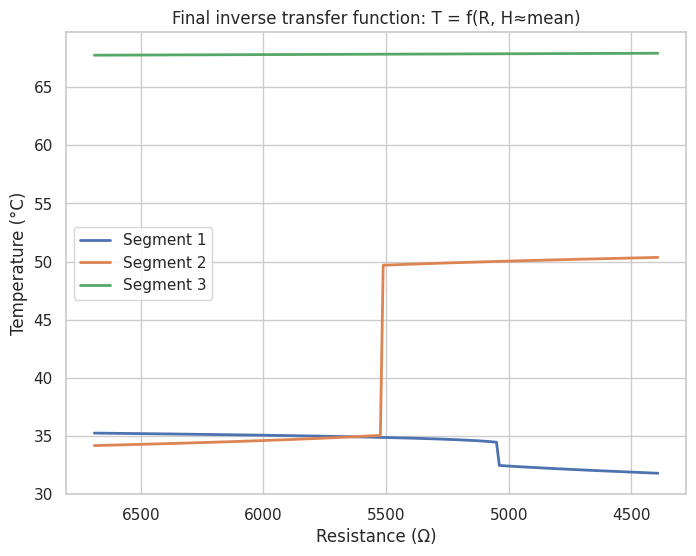

In [30]:
# Cell AA: Numerically invert R = f(T,H) → T = f(R,H)

from numpy.polynomial import Polynomial

inverse_segments = []
for i, (poly, lin) in enumerate(models):
    # Get polynomial terms and coefficients
    feature_names = poly.get_feature_names_out(['T','H'])
    coefs = lin.coef_
    intercept = lin.intercept_
    print(f"\nSegment {i+1} polynomial terms:")
    for name, coef in zip(feature_names, coefs):
        print(f"  {name:10s}: {coef: .3e}")

    # Build numeric inversion for given humidity values
    H_fixed = np.mean(dfc['H'])  # assume nominal humidity for inversion
    R_range = np.linspace(dfc['R_smooth'].min(), dfc['R_smooth'].max(), 200)
    T_inv = []

    for r_val in R_range:
        # We solve for T numerically such that R_pred(T,H_fixed) = r_val
        def f_temp(Tval):
            X = poly.transform([[Tval, H_fixed]])
            return lin.predict(X)[0] - r_val
        try:
            from scipy.optimize import bisect
            # Temperature range of experiment (adjust if needed)
            T_root = bisect(f_temp, 20, 110)
            T_inv.append(T_root)
        except Exception:
            T_inv.append(np.nan)
    inverse_segments.append((R_range, np.array(T_inv)))

# Plot inverse calibration curves
plt.figure(figsize=(8,6))
for i, (R_range, T_inv) in enumerate(inverse_segments):
    plt.plot(R_range, T_inv, lw=2, label=f'Segment {i+1}')
plt.gca().invert_xaxis()
plt.xlabel('Resistance (Ω)')
plt.ylabel('Temperature (°C)')
plt.title('Final inverse transfer function: T = f(R, H≈mean)')
plt.legend()
plt.grid(True)
plt.show()


In [31]:
# Cell AB: Save inversion results as lookup table
lut_data = []
for i, (R_range, T_inv) in enumerate(inverse_segments):
    df_lut = pd.DataFrame({'Segment':i+1, 'R':R_range, 'T':T_inv})
    lut_data.append(df_lut)
lut_df = pd.concat(lut_data, ignore_index=True)
lut_df = lut_df.dropna()
lut_df.to_csv("/kaggle/working/final_calibration_LUT.csv", index=False)
print("✅ Lookup table saved: /kaggle/working/final_calibration_LUT.csv")

# Preview
display(lut_df.head(10))


✅ Lookup table saved: /kaggle/working/final_calibration_LUT.csv


,Segment,R,T
0,1,4390.893540,31.788991
1,1,4402.447775,31.799117
2,1,4414.002011,31.809270
3,1,4425.556246,31.819451
4,1,4437.110481,31.829661
5,1,4448.664716,31.839901
6,1,4460.218951,31.850174
7,1,4471.773186,31.860480
8,1,4483.327421,31.870820
9,1,4494.881656,31.881197
